In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
!pip install --upgrade tensorflow


Importation des bibliothèques requises:

In [ ]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from  tensorflow.keras.utils import load_img
from  tensorflow.keras.utils import img_to_array
from  keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extraction de fichiers:

In [ ]:
c = '/content/drive/MyDrive/Dataset/COVID'
l = '/content/drive/MyDrive/Dataset/Lung Opacity'
n = '/content/drive/MyDrive/Dataset/Normal'


In [ ]:
random.seed(42)
filenames = os.listdir(c)  + os.listdir(l) + os.listdir(n)

Classes:

- Normal -> 0

- Lung Opacity -> 1

- COVID -> 2

In [ ]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'Normal':
        categories.append(str(0))
    elif category == 'Lung_Opacity':
        categories.append(str(1))
    elif category == 'COVID':
        categories.append(str(2))

Convertir en Dataframe

In [ ]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Lung_Opacity' in filenames[i]:
        filenames[i] = os.path.join(l, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df

,filename,category
0,/content/drive/MyDrive/Dataset/COVID/COVID-104...,2
1,/content/drive/MyDrive/Dataset/COVID/COVID-101...,2
2,/content/drive/MyDrive/Dataset/COVID/COVID-1.png,2
3,/content/drive/MyDrive/Dataset/COVID/COVID-100...,2
4,/content/drive/MyDrive/Dataset/COVID/COVID-100...,2
...,...,...
2995,/content/drive/MyDrive/Dataset/Normal/Normal-9...,0
2996,/content/drive/MyDrive/Dataset/Normal/Normal-9...,0
2997,/content/drive/MyDrive/Dataset/Normal/Normal-9...,0
2998,/content/drive/MyDrive/Dataset/Normal/Normal-9...,0


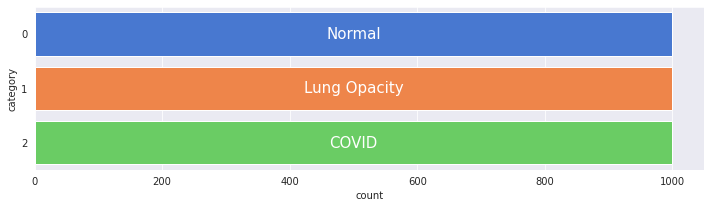

In [ ]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = df.sort_values(by='category'), y ='category',palette='muted', saturation=1)
plt.bar_label(container=splot.containers[0],
              labels=['Normal', 'Lung Opacity', 'COVID'],label_type='center', size=15, color='w')
plt.show()

**Analyse exploratoire des données**

Visualisation des données

- Un choix aléatoire


/content/drive/MyDrive/Dataset/Normal/Normal-657.png


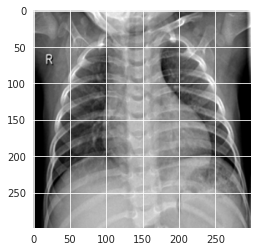

In [ ]:
sample = random.choice(df['filename'])
image = load_img(sample)
print(sample)
plt.imshow(image)
plt.show()

'Splitting Train, Validation & Test Data'

In [ ]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [ ]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.3, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

Augmentation des données

In [ ]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [ ]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 2400 validated image filenames belonging to 3 classes.


In [ ]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data,
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 180 validated image filenames belonging to 3 classes.


_________

### 'Model Training - VGG16'

Architecture de modèle

In [ ]:
baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

Résumé de modèle

In [ ]:
model.summary()

Optimiseur - Adam

In [ ]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Activation de GPU

Formation de modèle

In [ ]:
epochs = 200
checkpoint = ModelCheckpoint('model.h5',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history = model.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1,callbacks=[checkpoint], epochs=epochs)

Epoch 1/200
160/160 [==============================] - 1264s 8s/step - loss: 0.6394 - accuracy: 0.7088 - val_loss: 0.3860 - val_accuracy: 0.8778
Epoch 2/200
160/160 [==============================] - 37s 229ms/step - loss: 0.4859 - accuracy: 0.7900 - val_loss: 0.3560 - val_accuracy: 0.8667
Epoch 3/200
160/160 [==============================] - 36s 227ms/step - loss: 0.4256 - accuracy: 0.8200 - val_loss: 0.3187 - val_accuracy: 0.8667
Epoch 4/200
160/160 [==============================] - 36s 227ms/step - loss: 0.4013 - accuracy: 0.8329 - val_loss: 0.2777 - val_accuracy: 0.9111
Epoch 5/200
160/160 [==============================] - 36s 224ms/step - loss: 0.3887 - accuracy: 0.8404 - val_loss: 0.3155 - val_accuracy: 0.8667
Epoch 6/200
160/160 [==============================] - 39s 242ms/step - loss: 0.3594 - accuracy: 0.8562 - val_loss: 0.2551 - val_accuracy: 0.9222
Epoch 7/200
160/160 [==============================] - 38s 235ms/step - loss: 0.3582 - accuracy: 0.8521 - val_loss: 0.2498 - 



> Indented block



Sauvegarde de modéle

In [ ]:
model.save('model.h5')


'Plotting:
Training & Validation Loss
Training & Validation Loss'

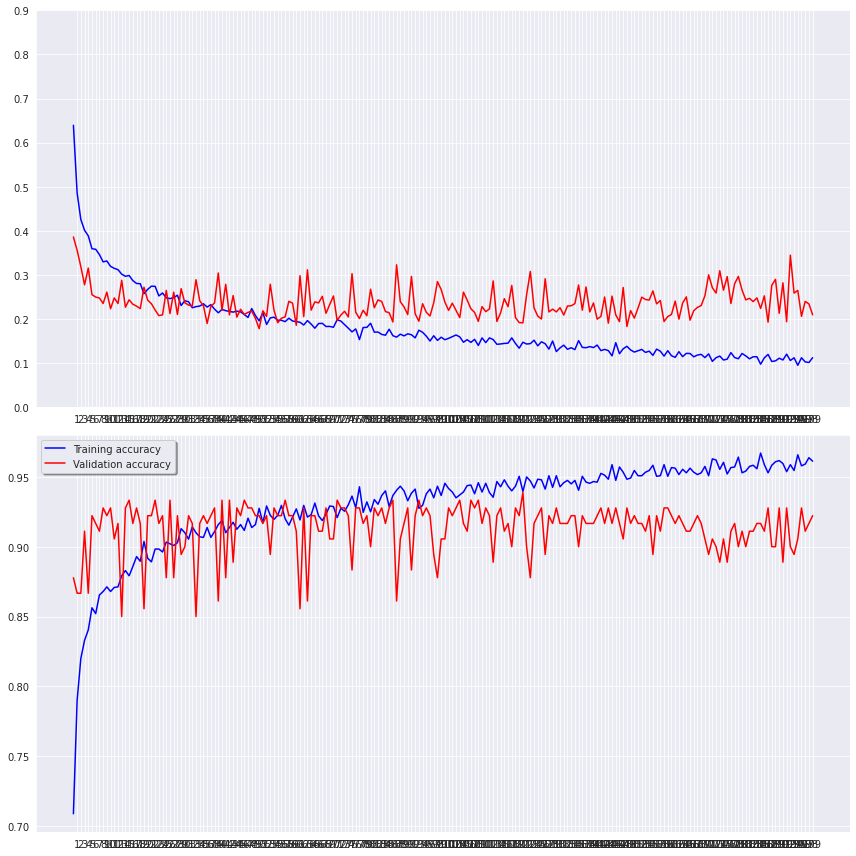

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()